# Variational AutoEncoders on CelebA

**The notebook has been adapted from the notebook provided in David Foster's Generative Deep Learning, 2nd Edition.**

- Book: [Amazon](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184/ref=sr_1_1?keywords=generative+deep+learning%2C+2nd+edition&qid=1684708209&sprefix=generative+de%2Caps%2C93&sr=8-1)
- Original notebook (tensorflow and keras): [Github](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/03_vae/03_vae_faces/vae_faces.ipynb)
- Dataset: [Kaggle](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset)

In [1]:
import os
import time
from PIL import Image

import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn import functional as F
from torchvision import transforms as Transform
from torchsummary import summary

from matplotlib import pyplot as plt

## 0. Train Parameters

In [2]:
DATA_DIR = '../../data/CelebFaces/img_align_celeba/img_align_celeba/'
DATA_FOlDER = '../../data/CelebFaces/'
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 64
EMBEDDING_DIM = 200
LEARNING_RATE = 1e-3
EPOCHS = 15
BETA = 1.2

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


## 1. Prepare dataset

In [3]:
class CelebA(Dataset):
    def __init__(self, image_dir):
        super().__init__()

        self.transform = Transform.Compose([
                 Transform.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                 Transform.ToTensor(),
        ])

        self.dir = image_dir
        self.imgs = os.listdir(image_dir)
        self.length = len(self.imgs)

    def __len__(self):
        return self.length

    def __getitem__(self, i):
        output_img = self.transform(Image.open(self.dir + self.imgs[i]))
        return output_img

In [4]:
def get_dataloaders():
    celeb_a = CelebA(DATA_DIR)
    train_ds, test_ds = random_split(celeb_a, [0.8, 0.2])
    print('Train data size: {}'.format(len(train_ds)))
    print('Test data size: {}'.format(len(test_ds)))
    
    train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=8, pin_memory=True)
    test_loader = DataLoader(dataset=test_ds, batch_size=BATCH_SIZE,
                             shuffle=False, num_workers=8, pin_memory=True)
    return train_loader, test_loader

Train data size: 162080
Test data size: 40519
torch.Size([128, 3, 64, 64])


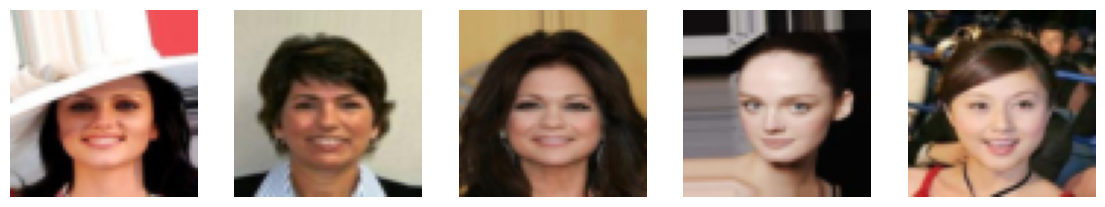

In [5]:
# Check dataset
check_ds, _ = get_dataloaders()
check_samples = next(iter(check_ds))
print(check_samples.shape)

plt.figure(figsize=(14, 3))
for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    img = check_samples[i].permute(1, 2, 0).clamp(0.0, 1.0)
    ax.imshow(img)
    ax.axis('off')

plt.show()

## 2. Building the Variational AutoEncoder

In [6]:
# Encoder
class Encoder(nn.Module):

    def __init__(self, latents, num_blocks=5):
        super().__init__()
        self.conv_module = nn.ModuleList()

        # Adding convolutional blocks to the module list
        for i in range(num_blocks):
            in_chan = 3 if i == 0 else NUM_FEATURES
            out_chan = NUM_FEATURES
            conv_block = nn.Sequential(
                nn.Conv2d(in_channels=in_chan,
                          out_channels=out_chan,
                          kernel_size=3,
                          stride=2,
                          padding=1),
                nn.BatchNorm2d(num_features=NUM_FEATURES),
                nn.LeakyReLU()
            )
            self.conv_module.append(conv_block)

        # Mapping features to mean and logvar
        self.mean = nn.Linear(in_features=256, out_features=EMBEDDING_DIM)
        self.logvar = nn.Linear(in_features=256, out_features=EMBEDDING_DIM)
        
    def forward(self, x):
        for module in self.conv_module:
            x = module(x)
        x = x.reshape(x.shape[0], -1)
        mean_x = self.mean(x)
        logvar_x = self.logvar(x)
        return mean_x, logvar_x

# encoder = Encoder(latents=EMBEDDING_DIM).to(DEVICE)
# summary(encoder, (3, 64, 64))


# # Decoder
class Decoder(nn.Module):

    def __init__(self, latents, num_blocks=5):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(in_features=EMBEDDING_DIM, out_features=256),
            nn.BatchNorm1d(num_features=256),
            nn.LeakyReLU()
        )
        
        self.trans_conv_module = nn.ModuleList()
        for _ in range(num_blocks):
            trans_conv = nn.Sequential(
                nn.ConvTranspose2d(in_channels=NUM_FEATURES, out_channels=NUM_FEATURES,
                                   kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.BatchNorm2d(num_features=NUM_FEATURES),
                nn.LeakyReLU()
            )
            self.trans_conv_module.append(trans_conv)

        self.output = nn.Sequential(
                            nn.Conv2d(in_channels=NUM_FEATURES,
                                      out_channels=3,
                                      kernel_size=3,
                                      padding=1),
                            nn.Sigmoid()
                            )

    def forward(self, x):
        x = self.fc(x)
        x = x.reshape(x.shape[0], 64, 2, 2)
        for module in self.trans_conv_module:
            x = module(x)
        return self.output(x)

# decoder = Decoder(latents=EMBEDDING_DIM).to(DEVICE)
# summary(decoder, (EMBEDDING_DIM,))

In [7]:
# Variational AutoEncoder
class VAE(nn.Module):
    def __init__(self, latents):
        super().__init__()
        self.encoder = Encoder(latents)
        self.decoder = Decoder(latents)

    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparameterize(mean, logvar)
        recon_x = self.decoder(z)
        return recon_x, mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar).to(DEVICE)
        eps = torch.randn(size=logvar.shape).to(DEVICE)
        return mean + std * eps

vae = VAE(EMBEDDING_DIM).to(DEVICE)
summary(vae, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 16, 16]          36,928
       BatchNorm2d-5           [-1, 64, 16, 16]             128
         LeakyReLU-6           [-1, 64, 16, 16]               0
            Conv2d-7             [-1, 64, 8, 8]          36,928
       BatchNorm2d-8             [-1, 64, 8, 8]             128
         LeakyReLU-9             [-1, 64, 8, 8]               0
           Conv2d-10             [-1, 64, 4, 4]          36,928
      BatchNorm2d-11             [-1, 64, 4, 4]             128
        LeakyReLU-12             [-1, 64, 4, 4]               0
           Conv2d-13             [-1, 64, 2, 2]          36,928
      BatchNorm2d-14             [-1, 6

## 3. Define the model, objective, and optimzer

In [8]:
def kl_divergence(mean, logvar):
    loss = -0.5 * (1 + logvar - torch.square(mean) -  torch.exp(logvar)).sum(axis=1)
    return loss.mean()

def mse_loss(recons_x, x):
    loss = ((recons_x - x) ** 2)
    loss = loss.reshape(loss.shape[0], -1).sum(axis=1)
    return loss.mean()

vae = VAE(EMBEDDING_DIM).to(DEVICE)

if torch.__version__.split('.')[0] == '2':
    torch.set_float32_matmul_precision('high')
    # It is important to use eager backend here to avoid
    # distribution mismatch in training and predicting
    vae = torch.compile(vae, backend="eager")
    print('model compiled')

# mse_loss_fn = nn.MSELoss(reduction='mean')
mse_loss_fn = mse_loss
kl_loss_fn = kl_divergence
optim = torch.optim.Adam(vae.parameters(), lr=LEARNING_RATE)

model compiled


## 4. Get dataloaders

In [9]:
train_loader, test_loader = get_dataloaders()

Train data size: 162080
Test data size: 40519


In [10]:
# A single epoch train funcion
def train(model, dataloader, optimizer, mse_loss_fn, kl_loss_fn):

    model.train()
    running_mse_loss = 0
    running_kl_loss = 0

    for i, train_x in enumerate(dataloader):
        optimizer.zero_grad()
        train_x = train_x.to(DEVICE)
        recon_x, mean, logvar = model(train_x)
        mse_loss = mse_loss_fn(recon_x, train_x)
        kl_loss = kl_loss_fn(mean, logvar)
        loss = mse_loss + BETA * kl_loss
        loss.backward()
        optimizer.step()

        running_mse_loss += mse_loss.item()
        running_kl_loss += kl_loss.item()

        del train_x, recon_x
        torch.cuda.empty_cache()

    return running_mse_loss / len(dataloader), running_kl_loss / len(dataloader)

# Validation function
def validate(model, dataloader, mse_loss_fn, kl_loss_fn):
    
    model.eval()
    running_mse_loss = 0
    running_kl_loss = 0
    
    for i, test_x in enumerate(dataloader):
        test_x = test_x.to(DEVICE)
        with torch.no_grad():
            recon_x, mean, logvar = model(test_x)
            mse_loss = mse_loss_fn(recon_x, test_x)
            kl_loss = kl_loss_fn(mean, logvar)

        running_mse_loss += mse_loss.item()
        running_kl_loss += kl_loss.item()
        
        del test_x, recon_x
        torch.cuda.empty_cache()

    return running_mse_loss / len(dataloader), running_kl_loss / len(dataloader)

## 5. Train and evaluate

In [11]:
for i in range(EPOCHS):
    prev_time = time.time()
    train_mse_loss, train_kl_loss = train(vae, train_loader, optim, mse_loss_fn, kl_loss_fn)
    test_mse_loss, test_kl_loss = validate(vae, test_loader, mse_loss_fn, kl_loss_fn)

    curr_time = time.time()
    print('Epoch: {}\tepoch time {:.2f} min'.format(
        i + 1, (curr_time - prev_time) / 60
    ))
    
    print(f'\tTrain - mse_loss: {train_mse_loss:.4f}, kl_loss: {train_kl_loss:.4f}')
    print(f'\tValid - mse_loss: {test_mse_loss:.4f}, kl_loss: {test_kl_loss:.4f}')

Epoch: 1	epoch time 1.19 min
	Train - mse_loss: 293.0011, kl_loss: 41.9248
	Valid - mse_loss: 212.1748, kl_loss: 42.8295
Epoch: 2	epoch time 1.17 min
	Train - mse_loss: 199.3022, kl_loss: 42.8398
	Valid - mse_loss: 181.5620, kl_loss: 45.0702
Epoch: 3	epoch time 1.18 min
	Train - mse_loss: 183.1500, kl_loss: 45.1923
	Valid - mse_loss: 171.9562, kl_loss: 45.1282
Epoch: 4	epoch time 1.18 min
	Train - mse_loss: 175.6821, kl_loss: 46.5464
	Valid - mse_loss: 169.6351, kl_loss: 47.5816
Epoch: 5	epoch time 1.17 min
	Train - mse_loss: 170.7802, kl_loss: 47.5250
	Valid - mse_loss: 163.1426, kl_loss: 48.0958
Epoch: 6	epoch time 1.17 min
	Train - mse_loss: 167.2446, kl_loss: 48.3390
	Valid - mse_loss: 158.5289, kl_loss: 48.6174
Epoch: 7	epoch time 1.17 min
	Train - mse_loss: 164.2216, kl_loss: 48.9328
	Valid - mse_loss: 158.2835, kl_loss: 48.9015
Epoch: 8	epoch time 1.17 min
	Train - mse_loss: 161.8764, kl_loss: 49.3807
	Valid - mse_loss: 155.2409, kl_loss: 49.4290
Epoch: 9	epoch time 1.19 min
	Tr

In [12]:
# Save model
PATH = './models/vae_face.pt'
torch.save(vae.state_dict(), PATH)

In [13]:
# Load model
PATH = './models/vae_face.pt'
vae = VAE(EMBEDDING_DIM).to(DEVICE)
vae = torch.compile(vae, backend="eager")
pretrained_model = torch.load(PATH)
vae.load_state_dict(pretrained_model)

<All keys matched successfully>

## 6. Reconstruct using the Variational AutoEncoder

In [14]:
recons_batch = next(iter(test_loader))
recons_batch = recons_batch.to(DEVICE)

vae.eval()
with torch.no_grad():
    recons_x, mean, logvar = vae(recons_batch)

original_x = recons_batch.detach().cpu().permute(0, 2, 3, 1)
recons_x = recons_x.detach().cpu().permute(0, 2, 3, 1)

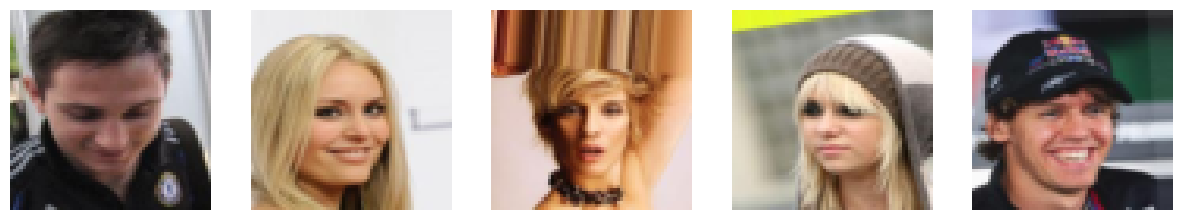

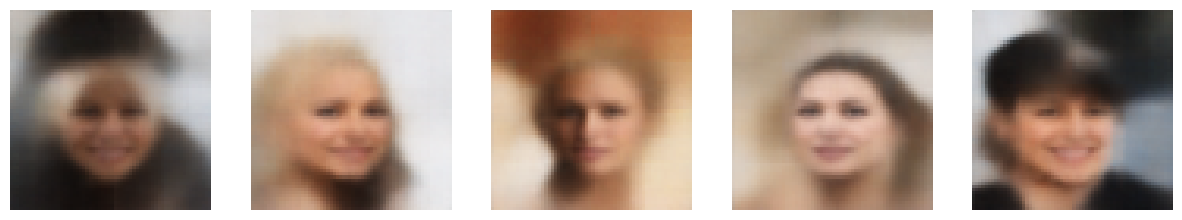

In [15]:
num_plots = 5

fig, axes = plt.subplots(1, num_plots, figsize=(15, 3))
rand_idcs = np.random.choice(128, size=num_plots, replace=True)

for i in range(num_plots):
    axes[i].imshow(original_x[rand_idcs[i]].clamp(0, 1))
    axes[i].axis('off')
plt.show()

fig, axes = plt.subplots(1, num_plots, figsize=(15, 3))
for i in range(num_plots):
    axes[i].imshow(recons_x[rand_idcs[i]])
    axes[i].axis('off')
plt.show()

## 7. Latent space distribution

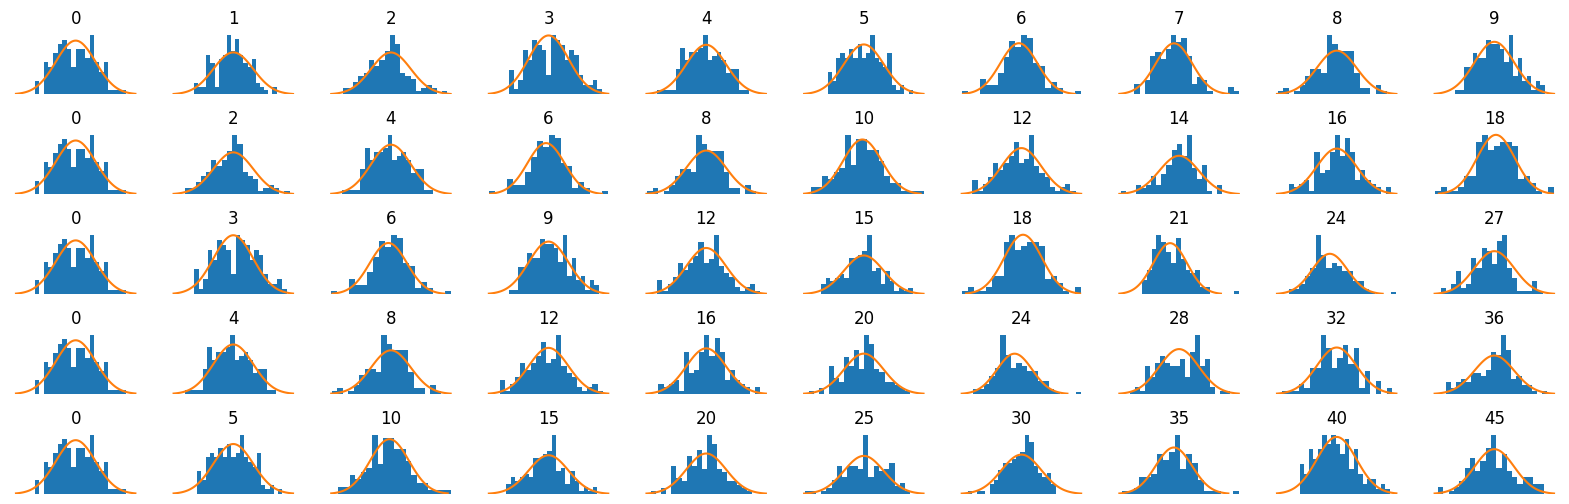

In [16]:
from scipy.stats import norm

num_rows = 5
num_cols = 10

# Get embeddings
with torch.no_grad():
    mean, logvar = vae.encoder(recons_batch)
    z = vae.reparameterize(mean, logvar)
    z = z.detach().cpu().numpy()

x = np.linspace(-3, 3, 100)
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 6))
fig.subplots_adjust(hspace=0.6)

for row in range(num_rows):
    for col in range(num_cols):
        ax = axes[row, col]
        ax.hist(z[:, row * col + col], density=True, bins=20)
        ax.plot(x, norm.pdf(x))
        ax.axis('off')
        ax.set_title(row * col + col)
        
plt.show()

## 8. Generate new faces

In [17]:
# randomly sample embeddings
grid_width, grid_height = (10, 3)

with torch.no_grad():
    embeddings = torch.randn(size=(grid_width * grid_height, EMBEDDING_DIM), device=DEVICE)
    generated_faces = vae.decoder(embeddings)

generated_faces = generated_faces.detach().cpu().permute(0, 2, 3, 1)

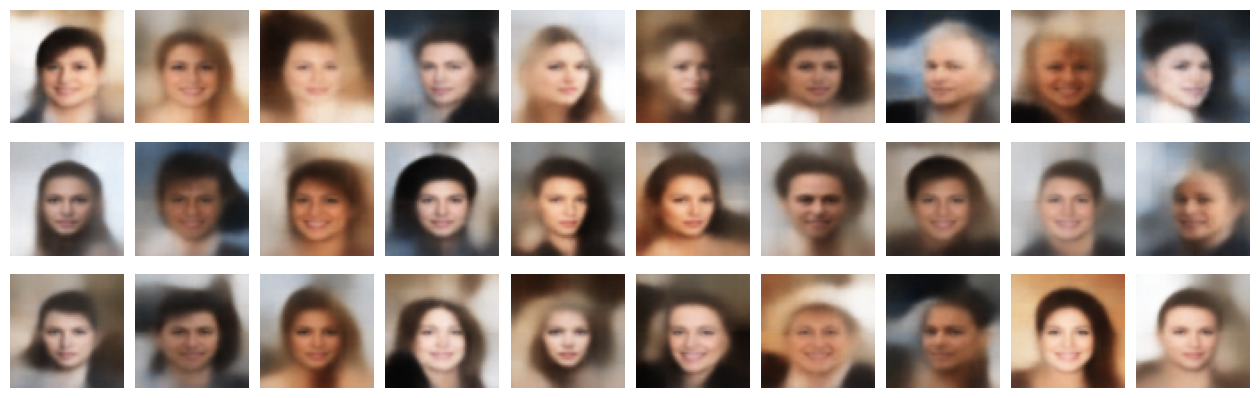

In [18]:
fig = plt.figure(figsize=(16, 5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis('off')
    ax.imshow(generated_faces[i].numpy())

plt.show()

## 9. Manipulate the images

In [19]:
from utils import *

label_file = DATA_FOlDER + 'list_attr_celeba.csv'
attributes = pd.read_csv(label_file)
print(attributes.columns)
attributes.head(10)

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1
5,000006.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,1,-1,1,-1,-1,1
6,000007.jpg,1,-1,1,1,-1,-1,1,1,1,...,-1,-1,1,-1,-1,-1,-1,-1,-1,1
7,000008.jpg,1,1,-1,1,-1,-1,1,-1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
8,000009.jpg,-1,1,1,-1,-1,1,1,-1,-1,...,-1,1,-1,-1,1,-1,1,-1,-1,1
9,000010.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,1,-1,-1,1


In [20]:
# Create dataset with the label included
class CelebA(Dataset):
    def __init__(self, image_dir, attributes, label):
        super().__init__()

        self.transform = Transform.Compose([
                 Transform.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                 Transform.ToTensor(),
        ])

        self.dir = image_dir
        self.imgs = attributes['image_id']
        self.labels = attributes[label]
        self.length = len(self.imgs)

    def __len__(self):
        return self.length

    def __getitem__(self, i):
        output_img = self.transform(Image.open(self.dir + self.imgs[i]))
        label = self.labels[i]
        return output_img, label

In [21]:
LABEL = 'Smiling'
_, labelled_test = random_split(CelebA(DATA_DIR, attributes, LABEL), [0.8, 0.2])
labelled_loader = DataLoader(labelled_test, batch_size=BATCH_SIZE,
                             shuffle=True, num_workers=4)

In [22]:
# Find the feature's vector
attribute_vec = get_vector_from_label(labelled_loader, EMBEDDING_DIM, LABEL, vae)

label: Smiling
images | POS move | NEG move | distance | 𝛥 distance:
    55 |    2.031 |    2.369 |    3.099 |    3.099
   378 |    0.323 |    0.355 |    1.491 |   -0.101
   691 |    0.180 |    0.175 |    1.387 |   -0.043
   998 |    0.112 |    0.126 |    1.294 |   -0.025
  1315 |    0.081 |    0.078 |    1.263 |   -0.010
  1618 |    0.064 |    0.070 |    1.240 |   -0.007
  1943 |    0.054 |    0.059 |    1.237 |    0.004
  2257 |    0.049 |    0.048 |    1.243 |   -0.004
  2569 |    0.041 |    0.047 |    1.241 |   -0.001
  2888 |    0.045 |    0.039 |    1.210 |   -0.007
Found the Smiling vector


### Feature transitioning

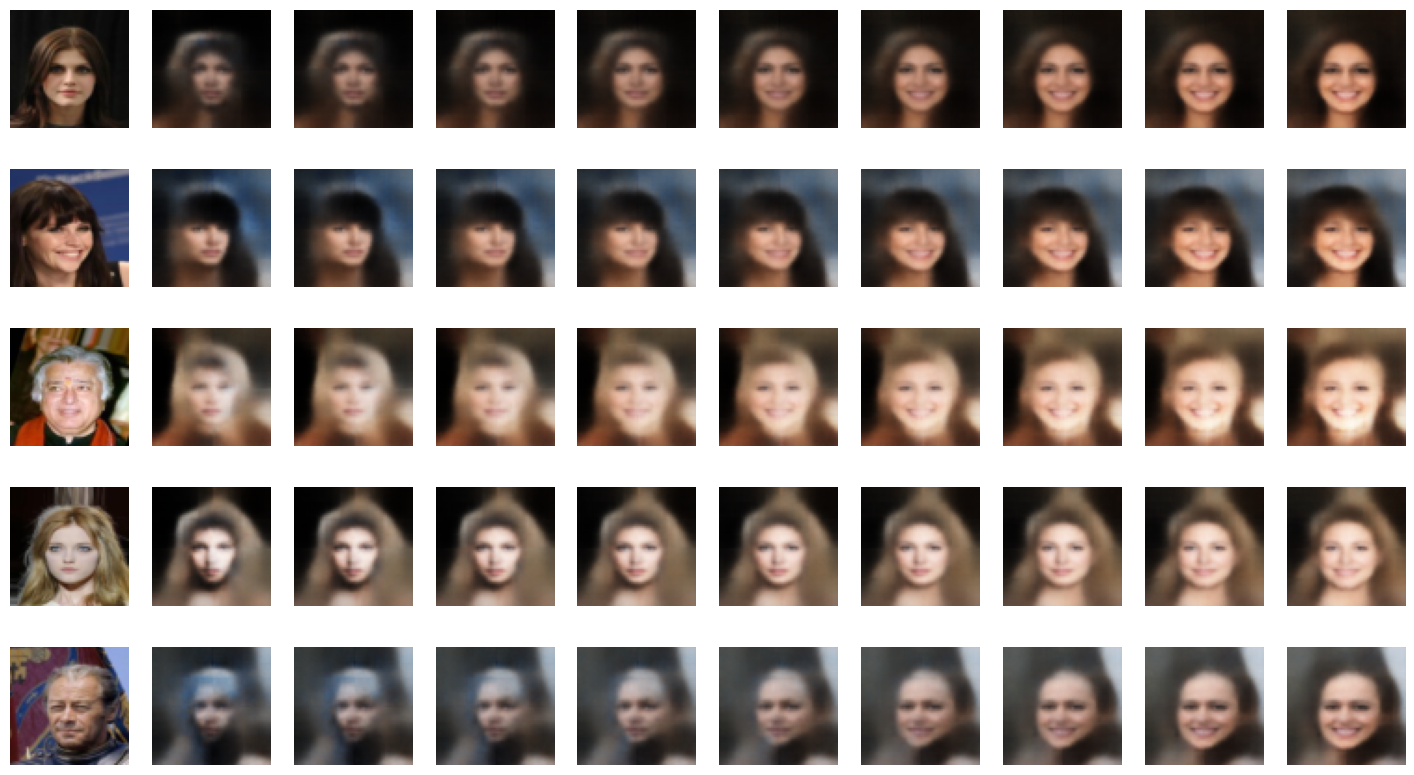

In [23]:
# Plot generated feature transitions
add_vector_to_images(labelled_loader, attribute_vec, vae)

### Morph faces

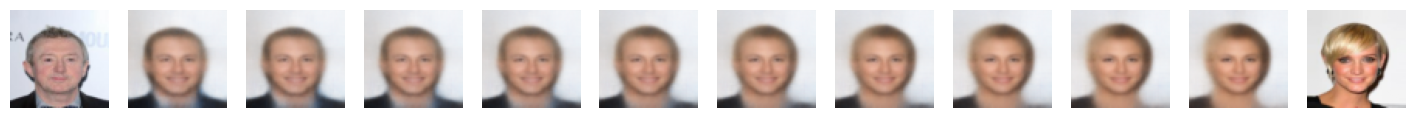

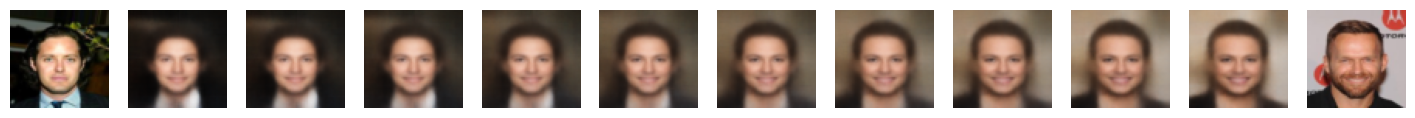

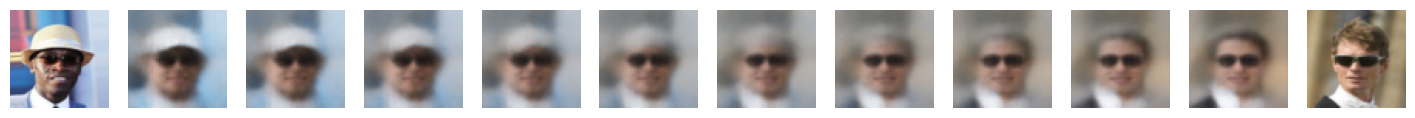

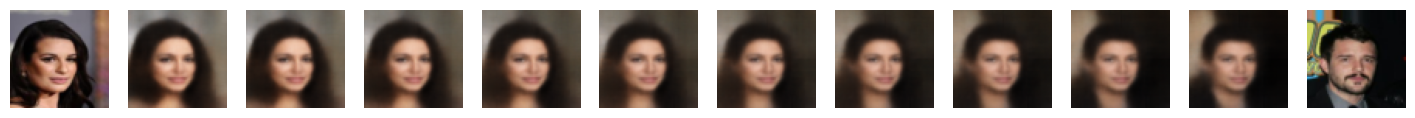

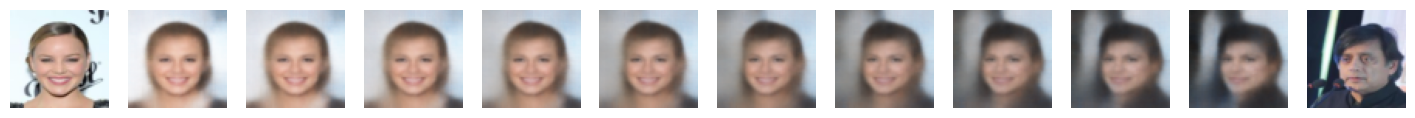

In [24]:
for _ in range(5):
    morph_faces(labelled_loader, vae)